# Autonomous Ship Transition Simulator

### 留意点
* pandasメインでデータを持たせていますが，不慣れのためあまりスマートでない記述になっています．もしもっとうまいやり方があれば教えてください．

In [1]:
# Import modules
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import yaml
import itertools

### Inputファイルの読み込み
以下のうち，現在は1で設定しています．
1. yamlファイルを用いてInputファイルを作成するパターン．初期値と変化率で設定．
* scenario: 船の需要や平均船齢など
* cost: 様々なコストなど
* spec: 様々な船タイプのスペック（主に，AsIsと比較した際の変化率で設定）

2. csvファイルを用いてInputファイルを用意しておくパターン．一定の変化率でなく，時系列変化を詳細に記述可能．
* demand: 船の需要
* cost: 様々なコストなど
* spec: 様々な船タイプのスペック（主に，AsIsと比較した際の変化率で設定）
※いくつかグローバル変数設定必要

```python
# Import from csv files (Optional)
cost = pd.read_csv("csv/cost.csv")
spec = pd.read_csv("csv/spec.csv")
demand = pd.read_csv("csv/demand.csv")
```

In [2]:
# Set scenario by yaml
def get_scenario(scenario='scenario_1'):
    check = True
    folder_pass = 'yml/scenario/'
    while check:
        try:
            with open(folder_pass + scenario + ".yml") as yml:
                scenario = yaml.load(yml,Loader = yaml.SafeLoader)
            check = False
        except:
            print(FILE_ERROR_MESSAGE)
            get_files(folder_pass)
            scenario = input("Set scenario %s (yml filename wo/extention)")

    column = ['Year', 'NumofShip', 'Newbuilding', 'Scrap']
    
    ship_initial = scenario['ship_demand']['initial_number']
    annual_growth = scenario['ship_demand']['annual_growth']
    ship_age = scenario['ship_age']
    start_year = scenario['sim_setting']['start_year']
    end_year = scenario['sim_setting']['end_year']

    Year = list(range(start_year, end_year+1))
    sim_years = len(Year)
    
    NumofShip = [0] * sim_years
    Newbuilding = [0] * sim_years
    Scrap = [0] * sim_years    
    for i in range (sim_years):
        NumofShip[i] = int(NumofShip[i-1] * annual_growth) if i>0 else ship_initial
        Scrap[i]= int(ship_initial/ship_age) if i <= ship_age else Newbuilding[i-ship_age]
        Newbuilding[i] = NumofShip[i] + Scrap[i] - NumofShip[i-1] if i>0 else int(ship_initial/ship_age)

    df_demand = pd.DataFrame(zip(Year, NumofShip, Newbuilding, Scrap), columns = column)
    return df_demand, ship_age

In [3]:
# Set cost time series by yaml
def get_cost(Year, cost='cost_1'):
    check = True
    folder_pass = 'yml/cost/'
    while check:
        try:
            with open(folder_pass + cost + ".yml") as yml:
                cost = yaml.load(yml,Loader = yaml.SafeLoader)
            check = False
        except:
            print(FILE_ERROR_MESSAGE)
            get_files(folder_pass)
            cost = input("Set cost %s (yml filename wo/extention)")
    
    column = ['Year','Seafarer','ShoreOperator','ExpLoss','CS','Comm','Situ','Plan','Exec','RemOpe','RemMon']
    
    sf_cost_initial = cost['seafarer_cost']['initial_number']
    sf_cost_growth = cost['seafarer_cost']['annual_growth']
    so_cost_initial = cost['shore_operator_cost']['initial_number']
    so_cost_growth = cost['shore_operator_cost']['annual_growth']
    loss_initial = cost['exp_loss']['initial_number']
    loss_growth = cost['exp_loss']['annual_growth']
    cs_initial = cost['opex_cyber_security']['initial_number']
    cs_growth = cost['opex_cyber_security']['annual_growth']
    com_initial = cost['opex_communication']['initial_number']
    com_growth = cost['opex_communication']['annual_growth']
    sa_initial = cost['capex_situation_awareness']['initial_number']
    sa_growth = cost['capex_situation_awareness']['annual_growth']
    pl_initial = cost['capex_planning']['initial_number']
    pl_growth = cost['capex_planning']['annual_growth']
    ex_initial = cost['capex_execution']['initial_number']
    ex_growth = cost['capex_execution']['annual_growth']
    ro_initial = cost['capex_remote_operation']['initial_number']
    ro_growth = cost['capex_remote_operation']['annual_growth']
    rm_initial = cost['capex_remote_monitoring']['initial_number']
    rm_growth = cost['capex_remote_monitoring']['annual_growth']    

    sim_years = len(Year)
    Seafarer = [0] * sim_years
    ShoreOperator = [0] * sim_years
    ExpLoss = [0] * sim_years  
    CS = [0] * sim_years
    Comm = [0] * sim_years
    Situ = [0] * sim_years
    Plan = [0] * sim_years
    Exec = [0] * sim_years
    RemOpe = [0] * sim_years
    RemMon = [0] * sim_years   

    for i in range (sim_years):
        Seafarer[i] = int(Seafarer[i-1] * sf_cost_growth) if i>0 else sf_cost_initial
        ShoreOperator[i] = int(ShoreOperator[i-1] * so_cost_growth) if i>0 else so_cost_initial
        ExpLoss[i] = int(ExpLoss[i-1] * loss_growth) if i>0 else loss_initial
        CS[i] = int(CS[i-1] * cs_growth) if i>0 else cs_initial
        Comm[i] = int(Comm[i-1] * com_growth) if i>0 else com_initial
        Situ[i] = int(Situ[i-1] * sa_growth) if i>0 else sa_initial
        Plan[i] = int(Plan[i-1] * pl_growth) if i>0 else pl_initial
        Exec[i] = int(Exec[i-1] * ex_growth) if i>0 else ex_initial
        RemOpe[i] = int(RemOpe[i-1] * ro_growth) if i>0 else ro_initial
        RemMon[i] = int(RemMon[i-1] * rm_growth) if i>0 else rm_initial
    
    df_cost = pd.DataFrame(zip(Year, Seafarer, ShoreOperator, ExpLoss, CS, Comm, Situ, Plan, Exec, RemOpe, RemMon), columns = column)
    return df_cost

In [4]:
# Set spec of each ship by yaml
def get_spec(spec='spec_1'):
    check = True
    folder_pass = 'yml/spec/'
    while check:
        try:
            with open(folder_pass + spec + ".yml") as yml:
                spec = yaml.load(yml,Loader = yaml.SafeLoader)
            check = False
        except:
            print(FILE_ERROR_MESSAGE)
            get_files(folder_pass)
            spec = input("Set spec %s (yml filename wo/extention)" % str(id)) # set each ship spec

    options = len(spec['SituationAwareness']) * len(spec['Control']) * len(spec['Control']) * len(spec['Remote'])
    column = ['ship_type', 'Control', 'Planning', 'SituationAwareness', 'Remote', 'sec_cost', 'com_cost', 'acc_ratio', 'sa_cost', 'pl_cost', 'ex_cost', 'ro_cost', 'rm_cost', 'num_sf', 'num_so']
    
    ship_type = [''] * options
    Control = [''] * options
    Planning = [''] * options
    SituationAwareness = [''] * options
    Remote = [''] * options
    sec_cost = [0] * options
    com_cost = [0] * options
    acc_ratio = [0] * options
    sa_cost = [0] * options
    pl_cost = [0] * options
    ex_cost = [0] * options
    ro_cost = [0] * options
    rm_cost = [0] * options
    num_sf = [0] * options
    num_so = [0] * options

    CPSR = list(itertools.product(spec['Control'], spec['Planning'], spec['SituationAwareness'],spec['Remote']))
    Control, Planning, SituationAwareness, Remote = [r[0] for r in CPSR], [r[1] for r in CPSR], [r[2] for r in CPSR], [r[3] for r in CPSR]
    
    for i in range(options):
        ship_type[i] = 'ship_' + str(i+1) 
        sec_cost[i] = spec['Control'][Control[i]]['sec_cost']+spec['Planning'][Planning[i]]['sec_cost']+spec['SituationAwareness'][SituationAwareness[i]]['sec_cost']+spec['Remote'][Remote[i]]['sec_cost']-4
        com_cost[i] = spec['Control'][Control[i]]['com_cost']+spec['Planning'][Planning[i]]['com_cost']+spec['SituationAwareness'][SituationAwareness[i]]['com_cost']+spec['Remote'][Remote[i]]['com_cost']-4
        acc_ratio[i] = spec['Control'][Control[i]]['acc_ratio']*spec['Planning'][Planning[i]]['acc_ratio']*spec['SituationAwareness'][SituationAwareness[i]]['acc_ratio']
        sa_cost[i] = spec['SituationAwareness'][SituationAwareness[i]]['sa_cost']
        pl_cost[i] = spec['Planning'][Planning[i]]['pl_cost']
        ex_cost[i] = spec['Control'][Control[i]]['ex_cost']
        ro_cost[i] = spec['Remote'][Remote[i]]['ro_cost']
        rm_cost[i] = spec['Remote'][Remote[i]]['rm_cost']
        num_sf_tmp = spec['Control'][Control[i]]['num_sf']+spec['Planning'][Planning[i]]['num_sf']+spec['SituationAwareness'][SituationAwareness[i]]['num_sf']
        num_so[i] = int(num_sf_tmp*spec['Remote'][Remote[i]]['num_so_ratio'])
        num_sf[i] = num_sf_tmp - num_so[i]
    
    spec = pd.DataFrame(zip(ship_type, Control, Planning, SituationAwareness, Remote, sec_cost ,com_cost ,acc_ratio ,sa_cost ,pl_cost ,ex_cost ,ro_cost ,rm_cost ,num_sf ,num_so), columns = column)
    return spec

In [5]:
# Function for ship selection
def select_ship(spec, cost, year, ship_age):
    opex_sum    = spec.num_sf * cost.Seafarer[year] \
                + spec.num_so * cost.ShoreOperator[year] \
                + spec.sec_cost * cost.CS[year] \
                + spec.com_cost * cost.Comm[year]
    capex_sum   = spec.sa_cost * cost.Situ[year] \
                + spec.pl_cost * cost.Plan[year] \
                + spec.ex_cost * cost.Exec[year] \
                + spec.ro_cost * cost.RemOpe[year] \
                + spec.rm_cost * cost.RemMon[year]
    ac_loss     = spec.acc_ratio * cost.ExpLoss[year]
    annual_cost = opex_sum + capex_sum/ship_age + ac_loss
    sf_sum      = spec.num_sf + spec.num_so
    select      = annual_cost.idxmin()
    
    return select, annual_cost, opex_sum, capex_sum, ac_loss, sf_sum

In [6]:
# Set yaml file
#@title What is your choice for ?　{ run: "auto" }

sa_growth = '0.9' #@param ['0.9','0.95','0.99']
pl_growth = '0.99' #@param ['0.9','0.95','0.99']
ex_growth = '0.99' #@param ['0.9','0.95','0.99']
ro_growth = '0.99' #@param ['0.9','0.95','0.99']

with open("yml/cost/cost_tmp.yml", "w") as yf:
    yaml.dump({
        "seafarer_cost": {
            "initial_number": 200000,
            "annual_growth": 1.01
        },
        "shore_operator_cost": {
            "initial_number": 100000,
            "annual_growth": 1.01
        },
        "exp_loss": {
            "initial_number": 300000,
            "annual_growth": 1.01
        },
        "opex_cyber_security": {
            "initial_number": 12000,
            "annual_growth": 1.01
        },
        "opex_communication": {
            "initial_number": 120000,
            "annual_growth": 0.99
        },
        "capex_situation_awareness": {
            "initial_number": 4000000,
            "annual_growth": float(sa_growth)
        },
        "capex_planning": {
            "initial_number": 6000000,
            "annual_growth": float(pl_growth)
        },
        "capex_execution": {
            "initial_number": 4000000,
            "annual_growth": float(ex_growth)
        },
        "capex_remote_operation": {
            "initial_number": 4000000,
            "annual_growth": float(ro_growth)
        },
        "capex_remote_monitoring": {
            "initial_number": 1000000,
            "annual_growth": 0.99
        }
    }, yf, default_flow_style=False)

In [7]:
# Import from yaml files
demand, ship_age = get_scenario('scenario_1')
cost = get_cost(demand.Year, 'cost_tmp')
spec = get_spec('spec_1')

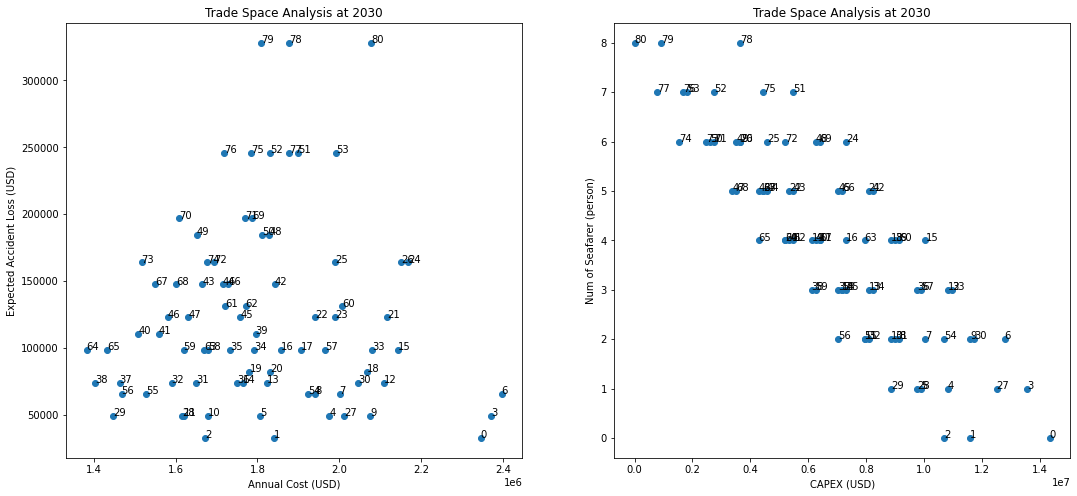

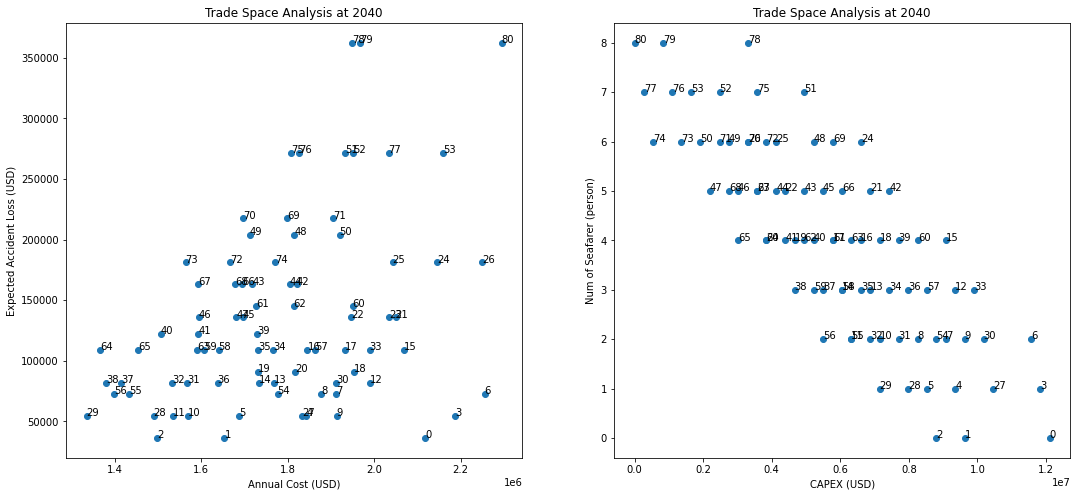

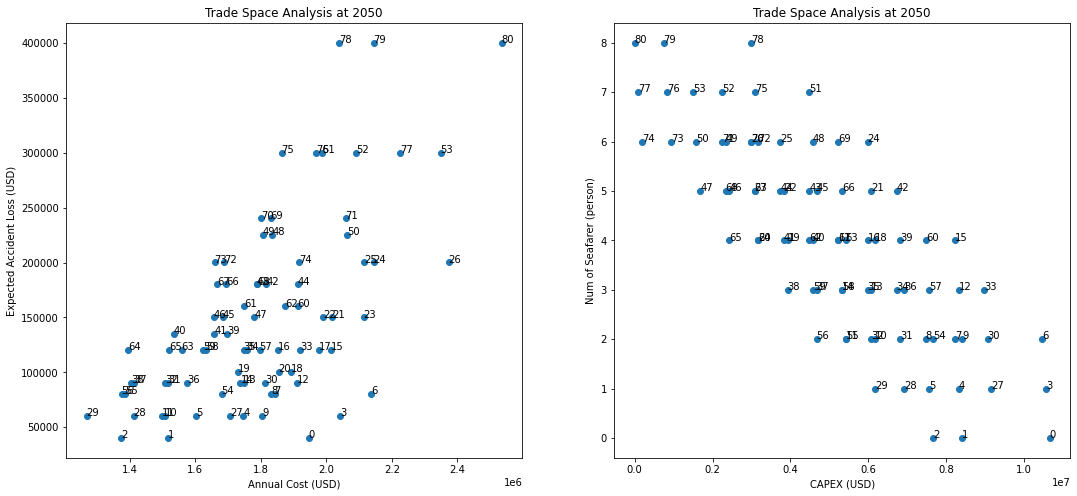

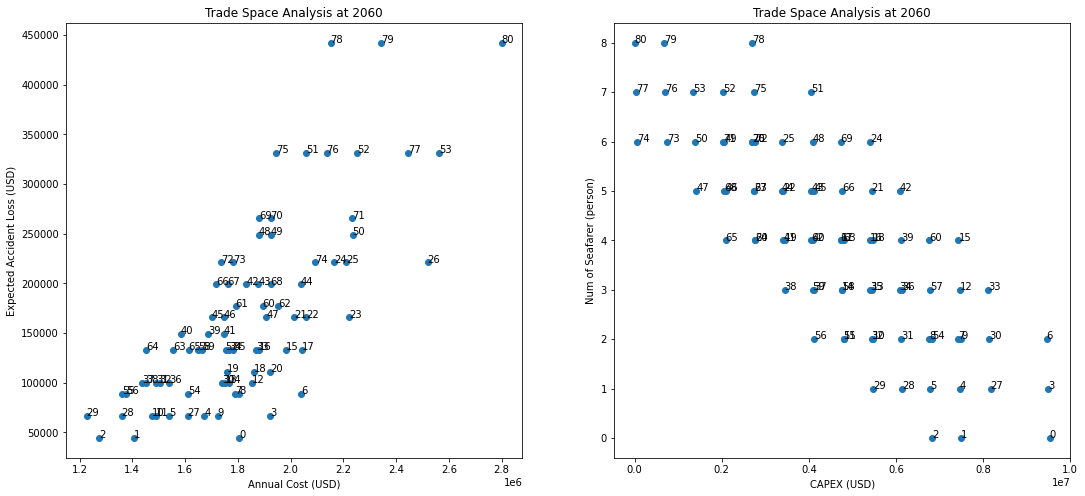

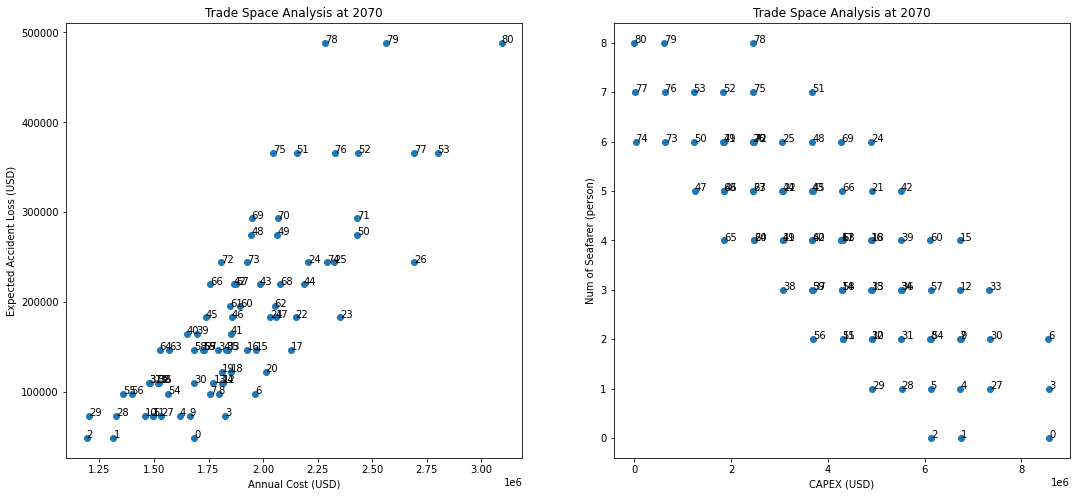

In [29]:
# Select Ship and show Tradespace
select = [0] * len(cost.Year)
labels = []

for i in range(len(cost.Year)):
    select[i], annual_cost, opex_sum, capex_sum, ac_loss, sf_sum = select_ship(spec, cost, i, ship_age)
    
    # Show tradespace
    if cost.Year[i]%10==0:
        fig = plt.figure(figsize=(18,8))
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(1, 2, 2)
        ax1.scatter(x=annual_cost, y=ac_loss)
        ax1.set_title("Trade Space Analysis at " + str(cost.Year[i]))
        ax1.set_xlabel("Annual Cost (USD)")
        ax1.set_ylabel("Expected Accident Loss (USD)")
        ax2.scatter(x=capex_sum, y=sf_sum)
        ax2.set_title("Trade Space Analysis at " + str(cost.Year[i]))
        ax2.set_xlabel("CAPEX (USD)")
        ax2.set_ylabel("Num of Seafarer (person)")
        for j, label in enumerate(spec.index.values):
            ax1.text(annual_cost[j], ac_loss[j], label)
            ax2.text(capex_sum[j], sf_sum[j], label)
        plt.show()

In [10]:
# Initiate result dataframe
result = pd.DataFrame(demand.Year)
for s in list(set(spec.ship_type[select])):
    result[s] = 0
# Add conventional ship
conv_ship = len(spec)-1
result[spec.ship_type[conv_ship]] = 0

In [12]:
# Calculate number of ships
result[spec.ship_type[conv_ship]][0] = demand.NumofShip[0] # Initial num of ship
for i in range(len(cost.Year)):
    for s in list(set(spec.ship_type[select])):
        result.at[i,s] = result.at[i-1,s] if i >= 1 else 0
    result[spec.ship_type[select[i]]][i] += demand.Newbuilding[i]
    if i-ship_age > 0:
        result[spec.ship_type[select[i-ship_age-1]]][i] -= demand.Newbuilding[i-ship_age-1]
    if i >= 1 and i <= ship_age:
        result[spec.ship_type[conv_ship]][i] = result[spec.ship_type[conv_ship]][i-1] - demand.Scrap[i]

In [14]:
# Function for result calculation
def result_calc(s, spec, cost, year, num, ship_age):
    i = spec.index[spec.ship_type == s].tolist()[0]
    LabourCost = (spec.num_sf[i] * cost.Seafarer[year] + spec.num_so[i] * cost.ShoreOperator[year]) * num
    OpeCost = (spec.sec_cost[i] * cost.CS[year] + spec.com_cost[i] * cost.Comm[year]) * num
    OnboardAsset = (spec.sa_cost[i] * cost.Situ[year] + spec.pl_cost[i] * cost.Plan[year] + spec.ex_cost[i] * cost.Exec[year])/ship_age * num
    ShoreAsset = (spec.ro_cost[i] * cost.RemOpe[year] + spec.rm_cost[i] * cost.RemMon[year])/ship_age * num 
    LossDamage = (spec.acc_ratio[i] * cost.ExpLoss[year]) * num
    Seafarer = spec.num_sf[i] * num
    ShoreOperator = spec.num_so[i] * num
    
    return LabourCost, OpeCost, OnboardAsset, ShoreAsset, LossDamage, Seafarer, ShoreOperator

In [15]:
labels1 = list(set(spec.ship_type[select]))
labels1.append(spec.ship_type[conv_ship])
labels1 = sorted(labels1, reverse=True)

# Calculate Other Parameters
result['LabourCost'] = 0
result['OpeCost'] = 0
result['OnboardAsset'] = 0
result['ShoreAsset'] = 0
result['LossDamage'] = 0
result['Seafarer'] = 0
result['ShoreOperator'] = 0
result['LossDamagePerVessel'] = 0
for i in range(len(cost.Year)):
    a = [0] * 7
    for s in labels1:
        new = list(result_calc(s, spec, cost, i, result.at[i,s], ship_age))
        a = [x + y for (x, y) in zip(a, new)]
    
    result.LabourCost[i], result.OpeCost[i], result.OnboardAsset[i], result.ShoreAsset[i], result.LossDamage[i], result.Seafarer[i], result.ShoreOperator[i] = a

result.LossDamagePerVessel = [a/b for (a,b) in zip(result.LossDamage, demand.NumofShip)]

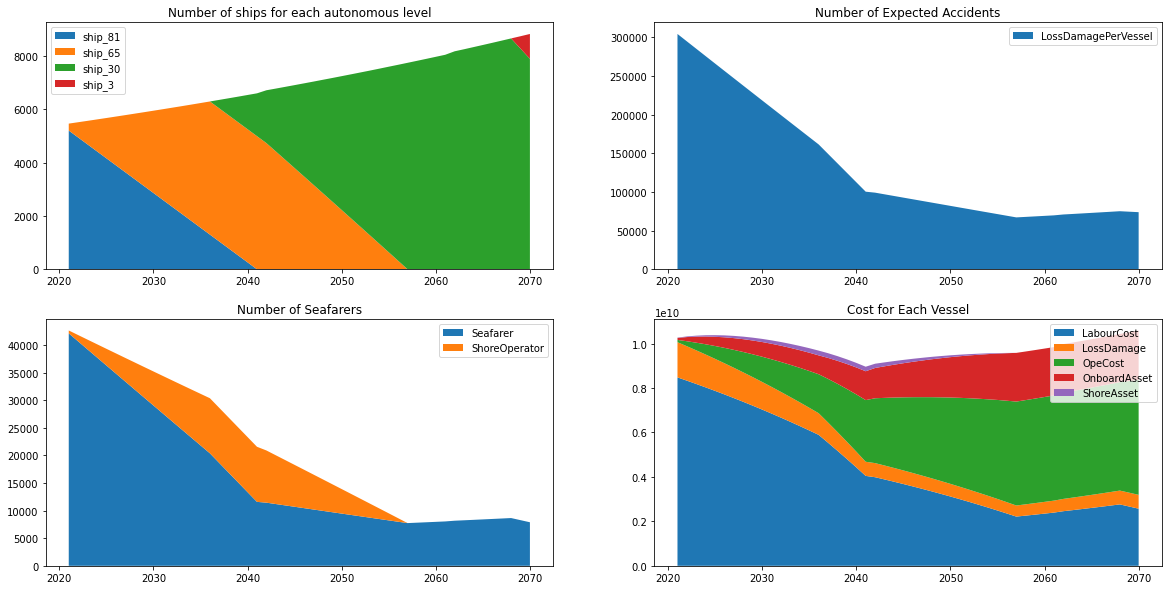

ship_81 | SituationAwareness: AsIs | Planning: AsIs | Control: AsIs | Remote: NaN
ship_65 | SituationAwareness: FullAuto | Planning: SemiAuto | Control: AsIs | Remote: Monitor
ship_30 | SituationAwareness: FullAuto | Planning: FullAuto | Control: SemiAuto | Remote: NaN
ship_3 | SituationAwareness: FullAuto | Planning: FullAuto | Control: FullAuto | Remote: NaN


In [16]:
# Show Outputs
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.stackplot(result.Year, [result[s] for s in labels1], labels=labels1)
ax1.set_title("Number of ships for each autonomous level")
ax1.legend(loc="upper left")

labels2 = ['LossDamagePerVessel']
ax2.stackplot(result.Year, result.LossDamagePerVessel, labels=labels2)
ax2.set_title("Number of Expected Accidents")
ax2.legend(loc="upper right")

labels3 = ['Seafarer', 'ShoreOperator']
ax3.stackplot(result.Year, result.Seafarer, result.ShoreOperator, labels=labels3)
ax3.set_title("Number of Seafarers")
ax3.legend(loc="upper right")

labels4 = ['LabourCost', 'LossDamage', 'OpeCost', 'OnboardAsset', 'ShoreAsset']
ax4.stackplot(result.Year, result.LabourCost, result.LossDamage, result.OpeCost, result.OnboardAsset, result.ShoreAsset, labels=labels4)
ax4.set_title("Cost for Each Vessel")
ax4.legend(loc="upper right")
plt.show()

for s in labels1:
    i = spec.index[spec.ship_type == s].tolist()[0]
    print(s, '| SituationAwareness:', spec.SituationAwareness[i], '| Planning:', spec.Planning[i], '| Control:', spec.Control[i], '| Remote:', spec.Remote[i])